In [36]:
import torch
import torch.nn as nn
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from torchinfo import summary
from torch.utils.data import Dataset, dataloader
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [37]:
print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
input_window = 7 # 7 days in week
output_window = 1 # predict for the next day
BATCH_SIZE = 100
print(device)

2.2.2+cu121
cuda


In [38]:
def parse_data(input_data, input_window, output_window):
    input_output_seq = []
    L = len(input_data)
    for i in range(L - input_window - output_window + 1):
        input_seq = input_data[i:i + input_window]
        output_seq = input_data[i + input_window:i + input_window + output_window]
        input_output_seq.append((input_seq, output_seq))
    return torch.FloatTensor(input_output_seq)

In [39]:
def get_data(data_raw, split):
    split = round(split * len(data_raw))
    train_data = data_raw[:split]
    test_data = data_raw[split:]

    train_data = train_data.cumsum()
    train_data = 2 * train_data  

    test_data = test_data.cumsum()

    train_sequence = parse_data(train_data, input_window)
    train_sequence = train_sequence[:-output_window]

    test_sequence = parse_data(test_data, input_window)
    test_sequence = test_sequence[:-output_window]

    return train_sequence.to(device), test_sequence.to(device)

In [40]:
composite_df = pd.read_csv("composite_stocks.csv")
#train_data, test_data = get_data()
DJI_close = composite_df['DJI']

In [41]:
DJI_log_prices = np.diff(np.log(DJI_close))
DJI_log_prices_cumsum = DJI_log_prices.cumsum()
DJI_close

0      33136.371094
1      33269.769531
2      32930.078125
3      33630.609375
4      33517.648438
           ...     
245    37385.968750
246    37545.328125
247    37656.519531
248    37710.101562
249    37689.539062
Name: DJI, Length: 250, dtype: float64

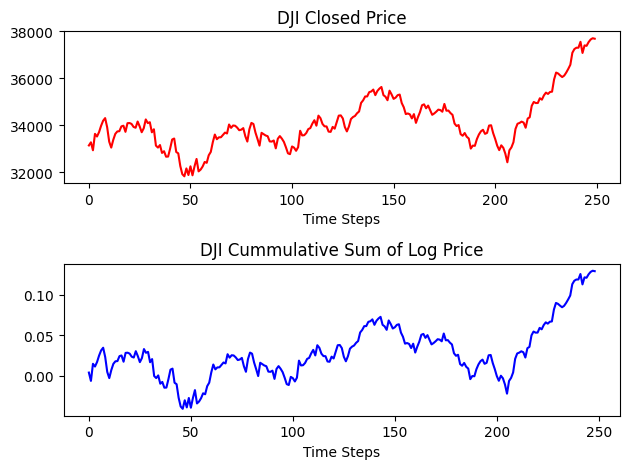

In [43]:
fig1, ax1 = plt.subplots(2, 1)
ax1[0].plot(DJI_close, color='red')
ax1[0].set_title('DJI Closed Price')
ax1[0].set_xlabel('Time Steps')

ax1[1].plot(DJI_log_prices_cumsum, color='blue')
ax1[1].set_title('DJI Cummulative Sum of Log Price')
ax1[1].set_xlabel('Time Steps')

fig1.tight_layout()